### **read data**

---



In [4]:
!pip install -q kaggle
!kaggle datasets download -d olgabelitskaya/flower-color-images
!unzip flower-color-images.zip -d flowers
import pandas as pd

Dataset URL: https://www.kaggle.com/datasets/olgabelitskaya/flower-color-images
License(s): other
 82% 41.0M/50.1M [00:00<00:00, 88.2MB/s]
100% 50.1M/50.1M [00:00<00:00, 88.1MB/s]
Archive:  flower-color-images.zip
  inflating: flowers/FlowerColorImages.h5  
  inflating: flowers/flower_images/flower_images/0001.png  
  inflating: flowers/flower_images/flower_images/0002.png  
  inflating: flowers/flower_images/flower_images/0003.png  
  inflating: flowers/flower_images/flower_images/0004.png  
  inflating: flowers/flower_images/flower_images/0005.png  
  inflating: flowers/flower_images/flower_images/0006.png  
  inflating: flowers/flower_images/flower_images/0007.png  
  inflating: flowers/flower_images/flower_images/0008.png  
  inflating: flowers/flower_images/flower_images/0009.png  
  inflating: flowers/flower_images/flower_images/0010.png  
  inflating: flowers/flower_images/flower_images/0011.png  
  inflating: flowers/flower_images/flower_images/0012.png  
  inflating: flowers/f

In [5]:
import os
import cv2
import numpy as np

In [6]:
df = pd.DataFrame([],columns=['path'])
main_path = '/content/flowers/flower_images/flower_images'
for image_name in os.listdir(main_path):
    df.loc[len(df)] = [os.path.join(main_path,image_name)]
array_list = []
for image_path in df['path']:
    img = cv2.imread(image_path)

    if img is not None:
        img = cv2.resize(img, (32, 32))
        img = img[:, :, ::-1]
        img = np.array(img, dtype=np.float32)
        img = img / 255

        array_list.append(img[:, :, ::-1])
        del img
    else:
        print("err")

array_list = np.array(array_list)
# gray_array_list = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2G) for img in array_list])

err




---



In [7]:
import tensorflow as tf
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-wwlornce
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-wwlornce
  Resolved https://github.com/tensorflow/docs to commit 82a582c520e0674e3232bf99f3f1aa036d5a13c9
  Preparing metadata (setup.py) ... done


In [8]:
import glob
import imageio
import matplotlib.pyplot as plt
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

### **prepare the dataset**

---



In [10]:
train_images = array_list
train_images = train_images.astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize to [-1, 1]

In [11]:
BUFFER_SIZE = 210
BATCH_SIZE = 32

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### **The Generator**

---



In [13]:
# def make_generator_model():
#     model = tf.keras.Sequential()
#     model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())

#     model.add(layers.Reshape((8, 8, 256)))
#     assert model.output_shape == (None, 8, 8, 256)  # Note: None is the batch size

#     model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
#     assert model.output_shape == (None, 16, 16, 128)
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())

#     model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
#     assert model.output_shape == (None, 32, 32, 64)
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())

#     model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
#     assert model.output_shape == (None, 64, 64, 32)
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())

#     model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
#     assert model.output_shape == (None, 128, 128, 3)

#     return model



def make_generator_model():
    model = tf.keras.Sequential()

    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 32, 32, 3)

    return model

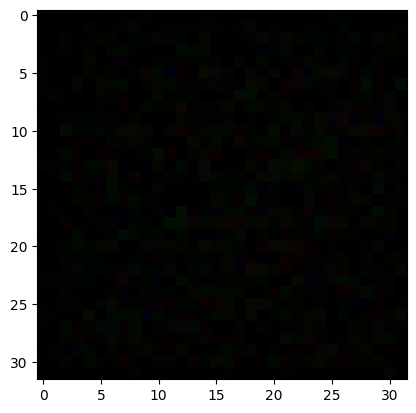

In [16]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, :])

### **The Discriminator**

---



In [17]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                            input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [18]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


tf.Tensor([[0.00116231]], shape=(1, 1), dtype=float32)


### **Define the loss and optimizers**

---



In [19]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) #auto softmax

In [20]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy((tf.ones_like(real_output)) * (0.9), real_output)
    fake_loss = cross_entropy((tf.zeros_like(fake_output)), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [21]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [22]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### **Save checkpoints**

---



In [23]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### **training loop**

---



In [24]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [25]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [26]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

### **Generate and save images**

---



In [27]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, :] * 127.5 + 127.5)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

### **Train the model**
---



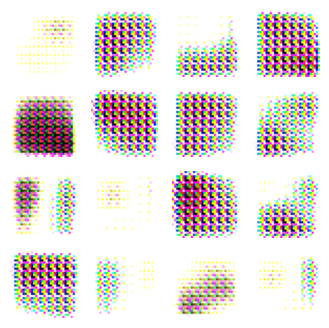

In [28]:
train(train_dataset, EPOCHS)

In [29]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

### **GIF**

---



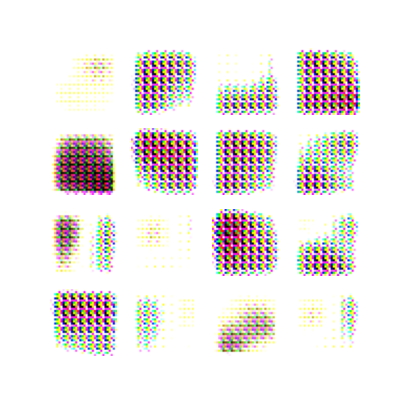

In [30]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))
display_image(EPOCHS)

In [31]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-31-56bb6d34be2e>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-31-56bb6d34be2e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



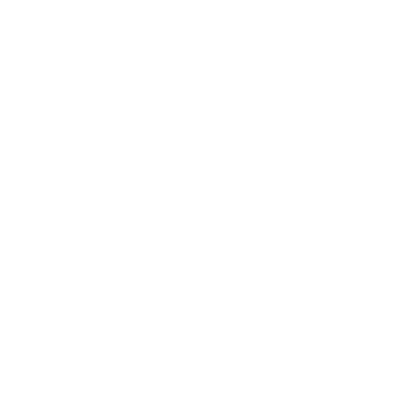

In [32]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)